In [12]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# from joblib import dump

from load_data import get_lidar, get_encoder, get_imu
from p3_util import replay_lidar
from MapUtils.bresenham2D import bresenham2D

%matplotlib inline

### Load Training Data

In [2]:
dir_train_data = "./data/"
fnames = {'Encoders':[], 'Hokuyo': [], 'imu': []}
for name in np.array(os.listdir(dir_train_data)):
    for k in fnames.keys():
        if name.startswith(k):
            fnames[k].append(name.split(".")[0])
            continue
            
print(fnames)

{'Encoders': ['Encoders20', 'Encoders21', 'Encoders23'], 'Hokuyo': ['Hokuyo20', 'Hokuyo21', 'Hokuyo23'], 'imu': ['imu20', 'imu21', 'imu23']}


In [3]:
train_data = {}

def load_data(filename):
    fpath = os.path.join(dir_train_data, filename)
    if filename.startswith('Encoders'):
        return get_encoder(fpath)
    elif filename.startswith('Hokuyo'):
        return get_lidar(fpath)
    elif filename.startswith('imu'):
        return get_imu(fpath)
    else:
        print("Load data error:", filename)

for k, v in fnames.items():
    if k not in train_data:
        train_data[k] = {}

    for fname in v:
        train_data[k][fname] = load_data(fname)

for k in fnames.keys():
    print("-----------------", k, "-------------------")
    for key, val in train_data[k].items():
        print(key + ":", (len(val), len(val[0])))

----------------- Encoders -------------------
Encoders20: (5, 4956)
Encoders21: (5, 4789)
Encoders23: (5, 3809)
----------------- Hokuyo -------------------
Hokuyo20: (4962, 3)
Hokuyo21: (4785, 3)
Hokuyo23: (3803, 3)
----------------- imu -------------------
imu20: (7, 12187)
imu21: (7, 11730)
imu23: (7, 9416)


In [102]:
print(train_data['Hokuyo']['Hokuyo20'][0]['t'])
print(train_data['Hokuyo']['Hokuyo20'][1]['t'])
print(train_data['Hokuyo']['Hokuyo20'][3]['t'])



1298445274.550587
1298445274.574476
1298445274.618094


#### Lidar

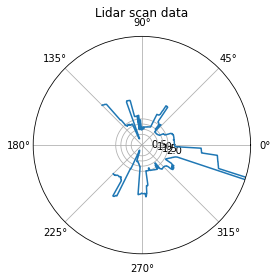

In [91]:
replay_lidar(train_data['Hokuyo']['Hokuyo20'][:210])

#### Encoder

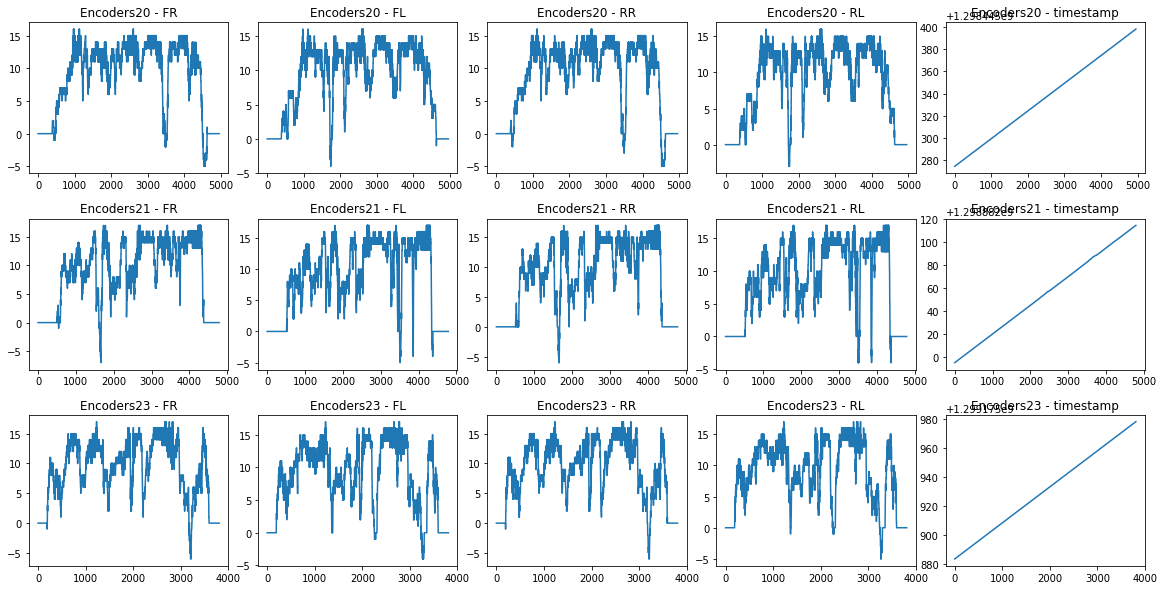

In [13]:
data = train_data["Encoders"]
titles = ["FR", "FL", "RR", "RL", "timestamp"]
PLT_COL = len(titles)
PLT_ROW = len(data)

plt.figure(figsize=[20, 10])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.3)

row, col = 0, 1
for k, v in data.items():
    col = 1
    for i in range(len(titles)):
        plt.subplot(PLT_ROW, PLT_COL, row * PLT_COL + col)
        plt.title(k + " - " + titles[col - 1])
        plt.plot(v[i])
        col += 1
    row += 1

### Dead-reckoning method with Encoder data

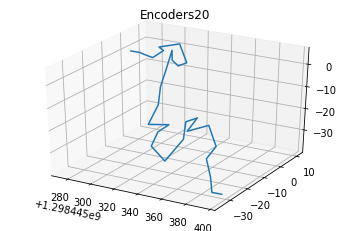

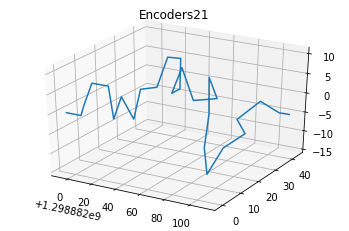

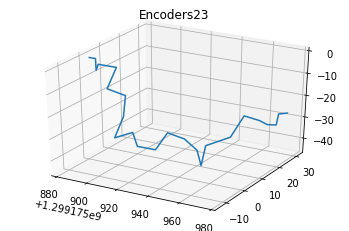

In [127]:
'''
Δs = (Δr + Δl) / 2
Δθ = (Δr - Δl) / 2L
Δx = Δs cos(θ + Δθ/2)
Δy = Δs sin(θ + Δθ/2)
'''

def getOdometry(data):    
    b = (311.15 + 476.25) / 2 / 1000.0
    wheel_diameter = (584.2 - 330.2) / 1000.0
    wheel_perimeter = 2 * np.pi * wheel_diameter
    cnt_2_distance = wheel_perimeter / 360.0
    sample_rate = 4

    delta_rs = data[0]
    delta_ls = data[1]
    timestamps = data[4]
    
    n = len(delta_rs)
    
    accu_r = [delta_rs[0]]
    for i in range(1, n):
        accu_r.append(accu_r[-1] + delta_rs[i])
    accu_l = [delta_ls[0]]
    for i in range(1, n):
        accu_l.append(accu_l[-1] + delta_ls[i])
    
    xs = [0]
    ys = [0]
    thetas = [0]
    sample_tms = [timestamps[0]]
    last_sample_i = 0
    for i in range(1, n):
        if timestamps[i] - timestamps[last_sample_i] < sample_rate:
            continue
          
        delta_r = accu_r[i] - accu_r[last_sample_i]
        delta_l = accu_l[i] - accu_l[last_sample_i]
        delta_theta = (delta_r - delta_l) / b
        delta_s = (delta_r + delta_l) / 2.0 * cnt_2_distance
        delta_x = delta_s * np.cos(thetas[-1] + delta_theta / 2.0) 
        delta_y = delta_s * np.sin(thetas[-1] + delta_theta / 2.0)
        
        xs.append(xs[-1] + delta_x)
        ys.append(ys[-1] + delta_y)
        thetas.append(thetas[-1] + delta_theta)
        sample_tms.append(timestamps[i])

        last_sample_i = i

    return np.array(xs), np.array(ys), np.array(thetas), np.array(sample_tms)


for k, v in train_data["Encoders"].items():
    xs, ys, thetas, timestamps = getOdometry(v)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(k)
    ax.plot3D(timestamps, xs, ys)

In [147]:
def sameplingLidarData(data, sample_rate):
    res = [data[0]]
    for i in range(1, len(data)):
        if data[i]['t'] - res[-1]['t'] < sample_rate:
            continue
        res.append(data[i])
    
    return np.array(res)

In [149]:
xs, ys, thetas, timestamps = getOdometry(train_data["Encoders"]["Encoders23"])
lidars = sameplingLidarData(train_data["Hokuyo"]['Hokuyo23'], 4)

print(xs.shape, ys.shape, thetas.shape, timestamps.shape)
print(lidars.shape)

(24,) (24,) (24,) (24,)
(24,)


(3, 48)

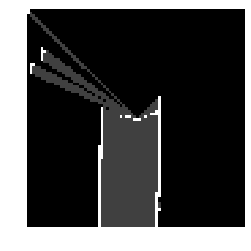

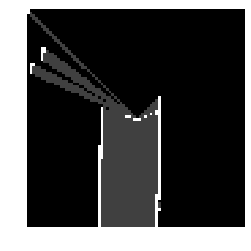

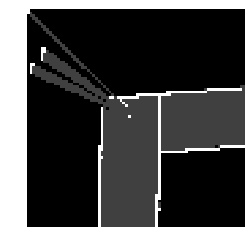

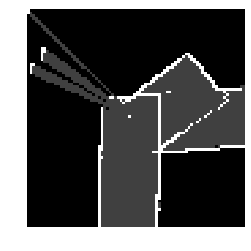

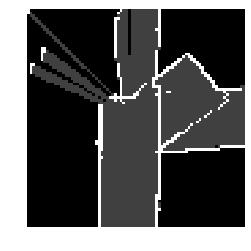

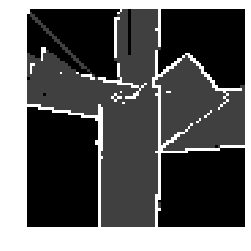

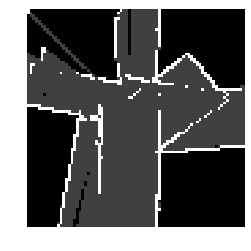

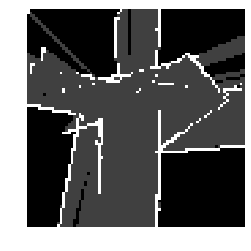

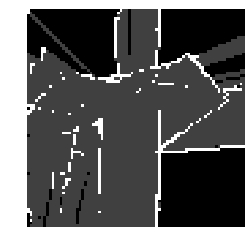

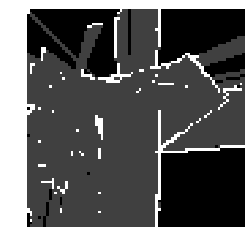

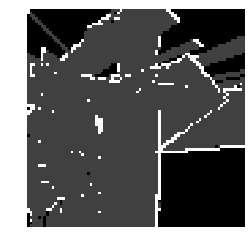

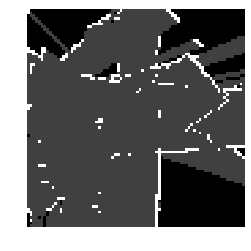

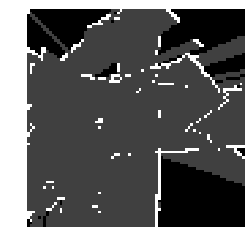

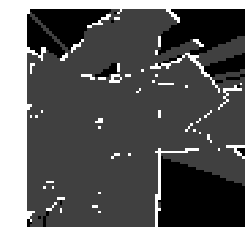

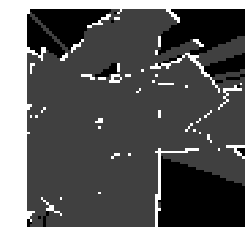

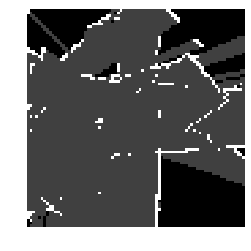

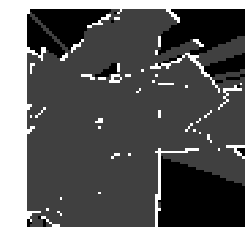

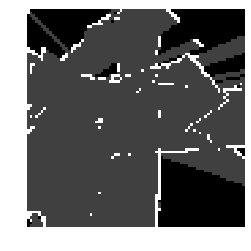

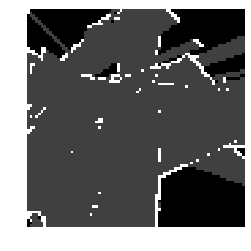

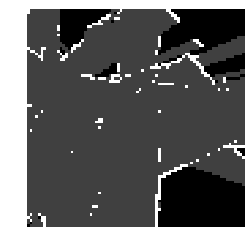

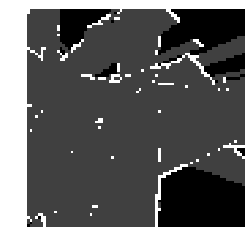

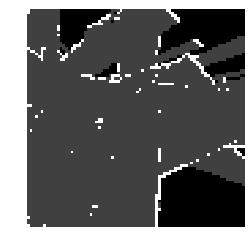

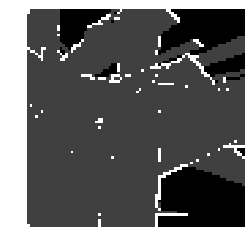

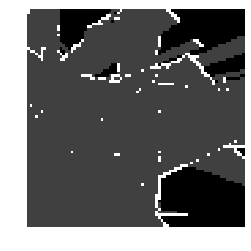

In [151]:
class Slam:
    def __init__(self):
        self.res = 0.1  # meter
        self.grid_size = 80
        self.ocpy_prob = np.log(0.7/0.3)
        self.empty_prob = np.log(0.3/0.7)
        
        self.grid = np.zeros((self.grid_size, self.grid_size))
        self.grid_orig = self.grid_size // 2
        
        self.map_size = int(self.grid_size / self.res)
        self.map_orig = self.map_size // 2
        
        
        
    
    def update(self, x, y, theta, scan):
        cx, cy = self.__pol2cart(scan, theta)
        
        # discretization
        cx = (cx / self.res).astype(int)
        cy = (cy / self.res).astype(int)
        
        wall_set = np.zeros_like(self.grid)
        empty_set = np.zeros_like(self.grid)
        for i in range(len(cx)):
            a, b = cx.item(i), cy.item(i)
            x1 = a + int(x) + self.grid_orig
            y1 = b + int(y) + self.grid_orig
            
            if 0 <= x1 < self.grid_size and 0 <= y1 < self.grid_size:
                wall_set[x1, y1] = 1

            line = np.array(bresenham2D(0, 0, a, b)).astype(int)
            for j in range(len(line[0]) - 1):
                x2 = line[0][j] + int(x) + self.grid_orig
                y2 = line[1][j] + int(y) + self.grid_orig
                if 0 <= x2 < self.grid_size and 0 <= y2 < self.grid_size:
                    empty_set[x2, y2] = 1

        self.grid[wall_set == 1] += self.ocpy_prob
        self.grid[empty_set == 1] += self.empty_prob

        # pixel value
        self.grid[self.grid >= 127] = 127
        self.grid[self.grid < -128] = -128
        
            
    def show(self):
        fig = self.grid.copy()
        fig[self.grid > 0] = 2
        fig[np.logical_and(0 <= self.grid, self.grid <= 0)] = 0
        fig[self.grid < 0] = 0.5
        
        plt.figure()
        plt.axis('off')
        plt.imshow(fig, cmap='gray')
        plt.show()
        
        
    def __pol2cart(self, r, theta):
        '''
        Convert coordinates from polar to Cartesian.
        Theta ranges from -135 to 135.
        Args:
            r: radius (in meter), each sample has 1081 points
        Returns:
            x: x-coord of lidar scan
            y: y-coord of lidar scan
        '''
        # starting angle in radian
        start = -135 / 180 * np.pi
        theta = np.arange(start, -start, -2 * start / len(r)) + theta
        x, y = r * np.cos(theta), r * np.sin(theta)
        return x, y


slam = Slam()
for i in range(len(xs)):
    slam.update(xs[i], ys[i], thetas[i], lidars[i]['scan'])
    slam.show()


In [15]:
1.29917588e+09 - 1.29917588e+09

0.0